In [65]:
import pandas as pd
from datetime import timedelta
import numpy as np
from dateutil.relativedelta import *
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

### Import Data

In [5]:
# Get historical crypto market cap rank data
cryptoMarketCapRankDf = pd.read_csv('data\CryptoMarketCap.csv')
cryptoMarketCapRankDf['Date'] = pd.to_datetime(cryptoMarketCapRankDf['Date'])

In [6]:
# Get historical crypto price data
cryptoPriceDf = pd.read_csv('data\TradingViewCryptoPrice.csv', index_col=0)
cryptoPriceDf.index = pd.to_datetime(cryptoPriceDf.index)

In [3]:
# Get Crpyto Category data
cryptoCategoryDf = pd.read_csv('data\CryptoCategory.csv', index_col=0)

In [4]:
cryptoCategoryDf

,Aave Tokens,Algorand Ecosystem,Alleged SEC Securities,Analytics,Animal Racing,Animoca Brands,Aptos Ecosystem,Arbitrum Ecosystem,Arbitrum Nova Ecosystem,Art,...,Wormhole Assets,Wrapped-Tokens,XDC Ecosystem,Yearn Ecosystem,Yearn Vault Tokens,Yield Aggregator,Yield Farming,Zero Knowledge (ZK),Zilliqa Ecosystem,ZkSync Ecosystem
0,aaave,algo,bnb,grt,derc,btc,apt,usdt,usdc,btc,...,wbtc,wbtc,xdc,yfi,yv1inch,cvx,uni,matic,zil,usdc
1,aammbptbalweth,opul,ada,cqt,rbw,eth,cake,usdc,dai,eth,...,audio,wnxm,eurs,sushi,yvaave,yfi,aave,imx,xcad,wbtc
2,aammbptwbtcweth,buy,sol,dext,hams,usdt,celr,wbtc,arb,usdt,...,avax,renbtc,ecoin,kp3r,yvcomp,alpha,snx,mina,xsgd,busd
3,aammdai,lmwr,trx,prq,antx,bnb,multi,link,ohm,bnb,...,axset,pbtc,gbex,xsushi,yvhegic,badger,crv,lrc,lunr,woo
4,aammuniaaveweth,cct,ton,vib,rat,xrp,wing,dai,moon,xrp,...,bnb,rendoge,srx,cream,yvlink,bel,comp,zec,gzil,lusd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,gala,NaN,spool,NaN,gala,...,NaN,NaN,NaN,NaN,NaN,NaN,apy,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,sui,NaN,strp,NaN,sui,...,NaN,NaN,NaN,NaN,NaN,NaN,cns,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,dydx,NaN,grail,NaN,dydx,...,NaN,NaN,NaN,NaN,NaN,NaN,pacoca,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,cbeth,NaN,aidoge,NaN,cbeth,...,NaN,NaN,NaN,NaN,NaN,NaN,dis,NaN,NaN,NaN


### Formation Period

In [7]:
def marketCapCryptoSelection(cryptoMarketCapRankDf, cutoffDate, cutoffRank):
    # Get formation period sample crypto list
    marketCapCutoffDate = pd.to_datetime(cutoffDate) - timedelta(days=1)
    sampleCrypto = cryptoMarketCapRankDf[(cryptoMarketCapRankDf['Date'] == marketCapCutoffDate) & (cryptoMarketCapRankDf['Rank'] <= cutoffRank)]
    sampleCrypto = list(sampleCrypto['Symbol'])
    return sampleCrypto

In [8]:
def cryptoPriceCleaning(cryptoPriceDf, sampleCrypto, cutoffDate, lookback):
    # Fliter the crypto with formation period
    cutoffRowIdx = cryptoPriceDf.index.get_loc(cutoffDate)
    if cutoffRowIdx < lookback:
        # if there is not enough got the whole lookback period, just get all the availiable data
        sampleCryptoPrice = cryptoPriceDf.iloc[:cutoffRowIdx]
    else:
        sampleCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx-lookback:cutoffRowIdx]
    
    # Filter based on the availiablity of crpyto price
    sampleCrypto = set(sampleCrypto).intersection([x[7:-3] for x in sampleCryptoPrice.columns])

    # Data Cleaning
    sampleCryptoPrice = sampleCryptoPrice[["CRYPTO:" + x + "USD" for x in sampleCrypto]]
    sampleCryptoPrice = sampleCryptoPrice.ffill(axis=0)
    sampleCryptoPrice = sampleCryptoPrice.dropna(axis=1)

    print('Remaining number of crpyto: ', len(sampleCryptoPrice.columns))

    return sampleCryptoPrice

#### Cointegration Method

In [9]:
def cointegrationMethodSelection(sampleCryptoPrice, ADFtestThreshold):
    # Take log for the price series
    sampleCryptoLogPrice = np.log(sampleCryptoPrice)
    
    # Test all price series for order 1 integration
    I0Series = []
    for crypto in sampleCryptoLogPrice.columns:
        if adfuller(sampleCryptoLogPrice[crypto])[1] < ADFtestThreshold:
            I0Series.append(crypto)

    # remove price series with order 0 integration from samples
    sampleCryptoPrice = sampleCryptoPrice.drop(I0Series, axis=1)

    print('I0Series: ', I0Series)
    print('Remaining number of crpyto: ', len(sampleCryptoPrice.columns))

    # Finding cointegrated pairs
    CointegratedPairs = pd.DataFrame(columns=['Crypto 1', 'Crypto 2', 'Beta'])
    for crypto1 in sampleCryptoPrice.columns:
        for crypto2 in sampleCryptoPrice.columns:
            if crypto1 != crypto2:
                # OLS regression input
                y = sampleCryptoPrice[crypto1]
                x = sampleCryptoPrice[crypto2]
                x_withConst = sm.add_constant(x)

                # OLS Regression fitting
                model = sm.OLS(y, x_withConst).fit()

                # OLS Result
                const = model.params[0]
                beta = model.params[1]
                residuals = y - (x * beta + const)

                # the residuals are tested for stationarity by using the Augmented-Dickey-Fuller test (ADF-test)
                if adfuller(residuals)[1] < ADFtestThreshold:
                    CointegratedPairs.loc[len(CointegratedPairs)] = {'Crypto 1': crypto1, 'Crypto 2': crypto2, 'Beta': beta}
    
    return CointegratedPairs


In [53]:
# Grouping
# Coingecko https://www.coingecko.com/en/categories
# Crypto.com https://crypto.com/price/categories
# Coin Market Cap https://coinmarketcap.com/cryptocurrency-category/
# https://cryptorank.io/categories

def categoriesFilter(CointegratedPairs, cryptoCategoryDf):
    
    results = pd.DataFrame(columns=CointegratedPairs.columns)
    
    for idx, row in CointegratedPairs.iterrows():
        crypto1 = row['Crypto 1'][7:][:-3].lower()
        crypto2 = row['Crypto 2'][7:][:-3].lower()
        
        crypto1CategoriesList = []
        for category in cryptoCategoryDf.columns:
            if crypto1 in cryptoCategoryDf[category].values:
                crypto1CategoriesList.append(category)
       
        for category in crypto1CategoriesList:
            if crypto2 in cryptoCategoryDf[category].values:
                results.loc[len(results)] = row
                break
    
    return results

In [72]:
# Grouping
# Kmean
# https://blog.quantinsti.com/k-means-clustering-pair-selection-python/
# https://algotrading101.com/learn/cluster-analysis-guide/ (Easier version)

def KmeanFilter(sampleCryptoPrice, CointegratedPairs):
    
    inputData = pd.DataFrame(columns=['returns', 'volatility'])

    # Calculate the annulaized return and volatility of all sample Crpyto in the formation periods
    inputData['returns'] = sampleCryptoPrice.pct_change().mean()*266
    inputData['volatility'] = sampleCryptoPrice.pct_change().std()*np.sqrt(266)

    # scale the variables to (mean = 0, variance = 1)
    scale = StandardScaler().fit(inputData)
    inputData = pd.DataFrame(scale.fit_transform(inputData), columns = inputData.columns, index = inputData.index)
    
    # choosing the parameter K with silhouette method
    K = range(2,15)
    silhouettes = []

    # Fit the method
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
        kmeans.fit(inputData)
        silhouettes.append(silhouette_score(inputData, kmeans.labels_))
    
    kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
    K = kl.elbow

    # Fit the model
    k_means = KMeans(n_clusters=K)
    k_means.fit(inputData)
    prediction = k_means.predict(inputData)
    inputData['Group'] = prediction

    #########################################################################

    # Filter the pairs witin the same group
    results = pd.DataFrame(columns=CointegratedPairs.columns)
    
    for idx, row in CointegratedPairs.iterrows():
        crypto1 = row['Crypto 1']
        crypto2 = row['Crypto 2']
        
        if inputData.loc[crypto1,'Group'] == inputData.loc[crypto2,'Group']:
            results.loc[len(results)] = row

    
    return results
    
    

In [11]:
# Half-life
# Ornstein–Uhlenbeck process 
# https://pypi.org/project/ouparams/
# https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/6.1%20Ornstein-Uhlenbeck%20process%20and%20applications.ipynb
# half life: https://mathtopics.wordpress.com/2013/01/07/ornstein-uhlenbeck-process/

def halfLifeFilter(sampleCryptoPrice, CointegratedPairs, noOfPair):
        
        halfLifeList = []
        for i in range(len(CointegratedPairs)):
                # parameter
                crypto1 = CointegratedPairs.loc[i, 'Crypto 1']
                crypto2 = CointegratedPairs.loc[i, 'Crypto 2']
                beta = CointegratedPairs.loc[i, 'Beta']
                
                # Calculate the spread for formation period
                spread = sampleCryptoPrice[crypto1] - sampleCryptoPrice[crypto2] * beta
                # Calculate thr normilized spread in the formation period
                normalizedSpread = (spread - spread.mean()) / spread.std()

                x = list(normalizedSpread.iloc[:-1].reset_index(drop=True))
                y = list(normalizedSpread.iloc[1:].reset_index(drop=True))
                x_withConst = sm.add_constant(x)

                # OLS Regression fitting
                model = sm.OLS(y, x_withConst).fit()

                # OLS Result
                beta_ols = model.params[1]
                dt = 1 # dt is one day
                kappa_ols = -np.log(beta_ols) / dt
                halfLife = np.log(2) / kappa_ols
                halfLifeList.append(halfLife)
        
        CointegratedPairs['Half-life'] = halfLifeList
        CointegratedPairs = CointegratedPairs.sort_values('Half-life', ascending=True)
        CointegratedPairs = CointegratedPairs.iloc[:noOfPair].reset_index(drop=True)

        return CointegratedPairs


In [12]:
# cutoffDate = '2020-01-01'
# sampleCrypto = marketCapCryptoSelection(cryptoMarketCapRankDf, cutoffDate, cutoffRank)
# sampleCryptoPrice = cryptoPriceCleaning(cryptoPriceDf, sampleCrypto, cutoffDate, lookback)
# CointegratedPairs = cointegrationMethodSelection(sampleCryptoPrice, ADFtestThreshold)
# CointegratedPairs = categoriesFilter(CointegratedPairs, cryptoCategoryDf)

Remaining number of crpyto:  46
I0Series:  ['CRYPTO:USDTUSD']
Remaining number of crpyto:  45


### Trading Period (Need to consider close and open new positions in the same day)

In [8]:
def cointegrationMethodTrading(cryptoPriceDf, sampleCryptoPrice, CointegratedPairs, cutoffDate, forward, spreadThreshold, closeThreshold, constantModel=True):
    
    # initialize the records dataframe
    TransactionRecords = pd.DataFrame(columns=['Date', 'Crypto', 'Long/Short', 'Price', "Open/Close", "Transaction pair", "Round Trip No.", "Pair No.", "Quantity"])
    SpreadRecords = pd.DataFrame()
    PairNo = 0

    # get trading crpyto price
    cutoffRowIdx = cryptoPriceDf.index.get_loc(cutoffDate)
    if cutoffRowIdx + forward > len(cryptoPriceDf):
        # if there is not enough got the whole forward period, just get all the availiable data
        tradingCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx:]
    else:
        tradingCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx:cutoffRowIdx+forward]


    for i in range(len(CointegratedPairs)):
        ############ Trading Signal Calculation ############
        
        # parameter
        crypto1 = CointegratedPairs.loc[i, 'Crypto 1']
        crypto2 = CointegratedPairs.loc[i, 'Crypto 2']
        beta = CointegratedPairs.loc[i, 'Beta']

         # Calculate normalized spread
        if constantModel:
            # Calculate spread mean and std from formation period
            formationSpread = sampleCryptoPrice[crypto1] - sampleCryptoPrice[crypto1] * beta
            formationSpreadMean = formationSpread.mean()
            formationSpreadStd = formationSpread.std()

            # Calculate spread and normilized them in the trading period
            spread = tradingCryptoPrice[crypto1] - tradingCryptoPrice[crypto2] * beta
            normalizedSpread = (spread - formationSpreadMean) / formationSpreadStd

        else:
            # Expending window model
            # Combine the crpyto price from formation and trading period
            crypto1Price = pd.concat([sampleCryptoPrice[crypto1],tradingCryptoPrice[crypto1]], axis=0)
            crypto2Price = pd.concat([sampleCryptoPrice[crypto2],tradingCryptoPrice[crypto2]], axis=0)
            
            # Calculate the spread for both formation and trading period
            spread = crypto1Price - crypto2Price * beta
            # calculate spread mean and std in expaning window
            spreadMean = spread.expanding(min_periods=1).mean() # or df.rolling(window=len(df), min_periods=1).mean()
            spreadStd = spread.expanding(min_periods=1).std()

            # Calculate thr normilized spread in theformation and trading period
            normalizedSpread = (spread - spreadMean) / spreadStd
            # Extrate only the normalized spread from trading period
            normalizedSpread = normalizedSpread.loc[cutoffDate:]
        
        ############ Trading Execution ############
        # check if there is any trading opportunity
        SpreadWithoutLastDay = normalizedSpread.iloc[:-1]
        if len(SpreadWithoutLastDay[(SpreadWithoutLastDay >= spreadThreshold) | (SpreadWithoutLastDay <= -spreadThreshold)]) > 0:
            
            # save the spread records
            normalizedSpread.name = crypto1 + " " + crypto2
            SpreadRecords = SpreadRecords.merge(normalizedSpread, how='outer', left_index=True, right_index=True)

            # initialize before the transaction
            PairNo += 1
            normalizedSpread.name = 'spread'
            normalizedSpread = normalizedSpread.to_frame()
            Opened = False
            long = None
            RoundTripNo = 1

            for date in normalizedSpread.index:

                # When the trading date is not the last day
                if date != normalizedSpread.index[-1]:
                    # If there is an open position before that date
                    if Opened:
                        # Close postion if the spread cross closeThreshold
                        if not long and normalizedSpread.loc[date, 'spread'] <= closeThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, -beta]
                            RoundTripNo += 1
                            long = None
                            Opened = False
                            
                        elif long and normalizedSpread.loc[date, 'spread'] >= -closeThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, -beta]
                            RoundTripNo += 1
                            long = None
                            Opened = False
                            
                    
                    # Check again if there is any position, if no and fulfil the criteria, then open position 
                    if not Opened:
                        # short crypto 1 and long crypto 2 if spread >= spreadThreshold
                        if normalizedSpread.loc[date, 'spread'] >= spreadThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Open", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo, -beta]
                            long = False
                            Opened = True
                            
                        # long crypto 1 and short crypto 2 if spread <= -spreadThreshold
                        elif normalizedSpread.loc[date, 'spread'] <= -spreadThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Open", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo, -beta]
                            long = True
                            Opened = True
                            

                # For last day closing position
                else:
                    if Opened:
                        if not long:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, -beta]
                            long = None
                            Opened = False
                            
                        else:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo, 1]
                            if beta >= 0:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, beta]
                            else:
                                TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo, -beta]
                            long = None
                            Opened = False
                            
    return (TransactionRecords, SpreadRecords)

### Rolling Window

In [11]:
# General parameters
startDate = '2019-01-01'
endDate = '2023-07-01'
lookback =365
forward = 60

# Formation period paramenter
cutoffRank = 100
ADFtestThreshold = 0.01
# For Half-life filter
noOfPair = 50

# Trading period parameters
spreadThreshold = 2.5
closeThreshold = 0 # same sign as spreadThreshold

In [28]:
TransactionRecords = pd.DataFrame(columns=['Date', 'Crypto', 'Long/Short', 'Price', "Open/Close", "Transaction pair", "Period No.", "Pair No.", "Round Trip No.", "Quantity"])
SpreadRecords = pd.DataFrame()

period = 1
for cutoffDate in pd.date_range(startDate, endDate, freq='2MS'):
    sampleCrypto = marketCapCryptoSelection(cryptoMarketCapRankDf, cutoffDate, cutoffRank)
    sampleCryptoPrice = cryptoPriceCleaning(cryptoPriceDf, sampleCrypto, cutoffDate, lookback)
    CointegratedPairs = cointegrationMethodSelection(sampleCryptoPrice, ADFtestThreshold)
    CointegratedPairs = halfLifeFilter(sampleCryptoPrice, CointegratedPairs, noOfPair)
    Transaction, Spread = cointegrationMethodTrading(cryptoPriceDf, sampleCryptoPrice, CointegratedPairs, cutoffDate, forward, spreadThreshold, closeThreshold, False)
    Transaction['Period No.'] = period
    TransactionRecords = pd.concat([TransactionRecords, Transaction], ignore_index=True)
    SpreadRecords = pd.concat([SpreadRecords, Spread])
    period += 1

Remaining number of crpyto:  45
I0Series:  []
Remaining number of crpyto:  45
Remaining number of crpyto:  51
I0Series:  []
Remaining number of crpyto:  51
Remaining number of crpyto:  55
I0Series:  []
Remaining number of crpyto:  55
Remaining number of crpyto:  49
I0Series:  ['CRYPTO:USDTUSD']
Remaining number of crpyto:  48
Remaining number of crpyto:  47
I0Series:  []
Remaining number of crpyto:  47
Remaining number of crpyto:  48
I0Series:  ['CRYPTO:ZRXUSD', 'CRYPTO:USDTUSD', 'CRYPTO:SCUSD']
Remaining number of crpyto:  45
Remaining number of crpyto:  46
I0Series:  ['CRYPTO:USDTUSD']
Remaining number of crpyto:  45
Remaining number of crpyto:  47
I0Series:  ['CRYPTO:KCSUSD', 'CRYPTO:USDTUSD']
Remaining number of crpyto:  45
Remaining number of crpyto:  49
I0Series:  ['CRYPTO:LINKUSD', 'CRYPTO:USDTUSD', 'CRYPTO:TUSDUSD']
Remaining number of crpyto:  46
Remaining number of crpyto:  52
I0Series:  ['CRYPTO:USDTUSD', 'CRYPTO:TUSDUSD']
Remaining number of crpyto:  50
Remaining number of 

In [29]:
# TransactionRecords.to_csv('Transactions_cointegration_half-life.csv')
TransactionRecords = pd.read_csv('Transactions_cointegration_half-life.csv', index_col=0)
TransactionRecords

,Date,Crypto,Long/Short,Price,Open/Close,Transaction pair,Period No.,Pair No.,Round Trip No.,Quantity
0,2019-03-29,CRYPTO:MANAUSD,Long,0.060256,Open,CRYPTO:BATUSD,2,1,1,1.000000
1,2019-03-29,CRYPTO:BATUSD,Short,0.283268,Open,CRYPTO:MANAUSD,2,1,1,0.328311
2,2019-04-29,CRYPTO:MANAUSD,Short,0.048721,Close,CRYPTO:BATUSD,2,1,1,1.000000
3,2019-04-29,CRYPTO:BATUSD,Long,0.368466,Close,CRYPTO:MANAUSD,2,1,1,0.328311
4,2019-03-29,CRYPTO:BATUSD,Short,0.283268,Open,CRYPTO:MANAUSD,2,2,1,1.000000
...,...,...,...,...,...,...,...,...,...,...
1155,2023-06-29,CRYPTO:KAVAUSD,Long,0.934323,Close,CRYPTO:XTZUSD,27,10,1,0.532872
1156,2023-05-20,CRYPTO:HBARUSD,Long,0.053113,Open,CRYPTO:TRXUSD,27,11,1,1.000000
1157,2023-05-20,CRYPTO:TRXUSD,Short,0.072881,Open,CRYPTO:HBARUSD,27,11,1,1.952304
1158,2023-06-29,CRYPTO:HBARUSD,Short,0.048307,Close,CRYPTO:TRXUSD,27,11,1,1.000000


In [11]:
# SpreadRecords.to_csv('Spread_cointegration.csv')

### Transform transaction records to Result

In [30]:
result = pd.DataFrame(columns=['Period No.', 'Pair No.', 'Round Trip No.', 'Start Date', 'End Date', 'crypto 1', 'crypto 2', 'crypto 1 return', 'crypto 2 return', 'crypto 1 Long/Short', 'crypto 2 Long/Short', 'Quantity'])

for k in range(1, TransactionRecords['Period No.'].max() + 1):
    period =  TransactionRecords[TransactionRecords['Period No.'] == k]
    
    # if there is no trade in that period
    if len(period) == 0:
        continue

    # loop each pair of transactions
    for i in range(1, period['Pair No.'].max() + 1):
        pair = period[period['Pair No.'] == i]

        # loop each Round Trip in pair
        for j in range(1, pair['Round Trip No.'].max() + 1):
            roundTrip = pair[pair['Round Trip No.'] == j]

            returnResult = dict()

            # loop each crypto in the round trip
            for crypto in set(roundTrip['Crypto']):
                # prepare the specific round trip transaction record
                record = roundTrip[roundTrip['Crypto'] == crypto]
                record = record.reset_index(drop=True)

                # Calculate the return of the specific round trip
                returns = record['Price'][1] / record['Price'][0] - 1
                if record['Long/Short'][0] == 'Short':
                    returns = -returns 

                # Insert Record
                if len(returnResult) == 0:
                    returnResult['Period No.'] = k
                    returnResult['Pair No.'] = i
                    returnResult['Round Trip No.'] = j
                    returnResult['Start Date'] = record['Date'][0]
                    returnResult['End Date'] = record['Date'][1]
                
                if record['Quantity'][0] == 1:
                    returnResult['crypto 1'] = crypto
                    returnResult['crypto 1 return'] = returns
                    if record['Long/Short'][0] == 'Long':
                        returnResult['crypto 1 Long/Short'] = 1
                    else:
                        returnResult['crypto 1 Long/Short'] = -1
                else:
                    returnResult['crypto 2'] = crypto
                    returnResult['crypto 2 return'] = returns
                    returnResult['Quantity'] = record['Quantity'][0]
                    if record['Long/Short'][0] == 'Long':
                        returnResult['crypto 2 Long/Short'] = 1
                    else:
                        returnResult['crypto 2 Long/Short'] = -1

            result.loc[len(result)] = returnResult  


### Daily Return

In [31]:
def getcumReturns(cryptoPriceDf, result):
    cumReturn = pd.DataFrame()
    # loop through each row
    for idx, row in result.iterrows():
        crpyto1StartPrice = cryptoPriceDf.loc[row['Start Date'], row['crypto 1']]
        crpyto2StartPrice = cryptoPriceDf.loc[row['Start Date'], row['crypto 2']]
        crpyto1cumPnL = (cryptoPriceDf.loc[row['Start Date']:row['End Date'], row['crypto 1']] - crpyto1StartPrice) * row['crypto 1 Long/Short'] 
        crpyto2cumPnL = (cryptoPriceDf.loc[row['Start Date']:row['End Date'], row['crypto 2']] - crpyto2StartPrice) * row['crypto 2 Long/Short'] * row['Quantity']
        cumReturnSeries = (crpyto1cumPnL + crpyto2cumPnL) / (crpyto1StartPrice * 0.5 + crpyto2StartPrice * row['Quantity'] * 0.5) 
        cumReturnSeries.name = row['crypto 1'] + " " + row['crypto 2'] + " " + str(row['Period No.']) + " " + str(row['Round Trip No.'])
        cumReturn = cumReturn.merge(cumReturnSeries, left_index=True, right_index=True, how="outer")
    return cumReturn

In [32]:
cumReturns = getcumReturns(cryptoPriceDf, result)
dailyReturns = np.exp(np.log(cumReturns + 1).diff()) - 1 # OR (cumReturns + 1) / (cumReturns.shift(1) + 1) - 1
averageDailyReturn = dailyReturns.mean(axis=1)
averageDailyReturn = averageDailyReturn.fillna(0)
averageCumReturn = np.cumprod(1 +averageDailyReturn) - 1

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='Date'>

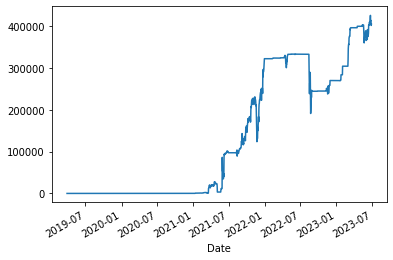

In [33]:
averageCumReturn.plot()

In [34]:
# Remark: return can be more than -100% for the short selling position
# result['Total Return'] = result['crypto 1 return'] + result['crypto 2 return'] * result['Quantity'] # not correct
result['Total Return'] = cumReturns.ffill(axis=0).iloc[-1].reset_index(drop=True)

In [25]:
result.groupby(['Period No.']).count()['Total Return']

Period No.
2      4
3      3
4     12
5      1
6      7
7     18
8     11
9     13
10    22
11     6
12    16
13    26
14    12
15    20
16     5
17    18
18    14
19     5
20    12
21    12
22     3
23     1
24    10
25    22
26     6
27    11
Name: Total Return, dtype: int64

In [35]:
result.groupby(['Period No.']).mean()['Total Return']

C:\Users\harry\AppData\Local\Temp\ipykernel_22844\64978782.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result.groupby(['Period No.']).mean()['Total Return']


Period No.
2    -0.145352
3     0.015311
4     0.187147
5     0.295784
6     0.289847
7     0.249861
8     0.431222
9     0.041066
10    0.093323
11    0.126893
12   -0.101054
13   -0.707809
14   -0.859983
15   -0.033174
16    0.172927
17    0.204852
18    0.074544
19    0.001408
20    0.015931
21    0.002249
22   -0.115083
23    0.002071
24    0.060495
25    0.070478
26    0.090967
27    0.046190
Name: Total Return, dtype: float64

In [ ]:
Period No.
2    -0.145352
3     0.015311
4     0.187147
5     0.295784
6     0.289847
7     0.249861
8     0.431222
9     0.041066
10    0.093323
11    0.126893
12   -0.101054
13   -0.707809
14   -0.859983
15   -0.033174
16    0.172927
17    0.204852
18    0.074544
19    0.001408
20    0.015931
21    0.002249
22   -0.115083
23    0.002071
24    0.060495
25    0.070478
26    0.090967
27    0.046190
Name: Total Return, dtype: float64

In [67]:
cumReturns.to_csv('cumReturns_cointegration.csv')

Time 0,
long crypto 1 $100 price 100 quantity 1
short crypto 2 $1.93*4 price 4 quantity 1.93 beta 1.93

Time 1,
long crypto 1 $101 price 101 quantity 1
short crypto 2 $1.93*5 price 5 quantity 1.93

 Return = [(101 - 100) - 1.93*(5 - 4)]/(100 + 1.93 * 4)*0.5

Comparing average performance of k-mean grouping, categories grouping, and all pairs for all periods.
### New part
- constructure portfolio of 20 pairs for half-life filter and FIFO (possiblely also include grouping)